# Duffing_analytical_REIN

This program is devoted to the solution of Duffing equation in the context of REIN experiment. This is based on the article from [N. Akerman, S. Kotler, Y. Glickman, Y. Dallal, A. Keselman, and R. Ozeri. Single-ion nonlinear mechanical oscillator, PRA 82 (2010)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.82.061402).

The solution is studied for different parameters.

Duffing equation considered here is

$$ 
\ddot{x} + 2\mu\dot{x} + \gamma\dot{x}^3 + \omega_0^2x + \alpha x^3 = k_t\cos{\omega_t t} + k_n\cos{(\omega_n t + \phi_n)}.
$$

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# sys.path.append("../Functions")
from calcium_constants import *

from numpy.polynomial import Polynomial

# %matplotlib qt
# %matplotlib inline
%load_ext watermark
%watermark

In [301]:
from matplotlib.pyplot import cm
cm = plt.get_cmap('turbo')
plt.rcParams['figure.figsize'] = [11.7, 8.3]
plt.rcParams.update({'font.size': 24})

In [383]:
class Duffing_analytical:
    '''
        Class to represent a 1D Doubly-Driven and Damped Anharmonic Oscillator (DDDAO).
        Uses the variable time-step method `solve_ivp` from `scipy` module to solve the ODE.
        The drives are the electric tickle and the NW as modelled by M. Weegen in his thesis.
        The solution can be computed for a range of parameters swept over time.
        The solution is first initialised, then alternates between a steady-state and a sweep.
        For each steady-state part, only the last part of the dynamics is saved to limit the memory usage.

        Based on
        N. Akerman, S. Kotler, Y. Glickman, Y. Dallal, A. Keselman, and R. Ozeri.
        Single-ion nonlinear mechanical oscillator, PRA 82 (2010).
        https://journals.aps.org/pra/abstract/10.1103/PhysRevA.82.061402.
    '''

    def __init__(self,
                V_tkl = 0.025, V_nw = 1, V_piezo = 1,  K_eq = None,
                omega_z = 422500*2*np.pi, omega_drive = 422500*2*np.pi,
                phi_tkl = 0, phi_nw = 0,                
                B = -4.84e19, assym = 0,
                cooling_rate = None, nl_damping_rate = None,
                P397 = 75e-6, w397 = 120e-6, lam_397 = 396.959120e-9,
                sweep_length = 21):
        '''
        Initialise the physical parameters of the trap coupling with nw, tickle and laser.
        Also initialise the parameters of the numerical simulation itself.
        Parameters
        ----------
        V_tkl : array-like or float
            Voltage applied to the tickle electrode.
        V_nw : array-like or float
            Voltage applied to the nanowire.
        V_piezo : array-like or float
            Voltage applied to the piezo element driving the oscillation of the nanowire.
            See Moritz thesis for more details about the modelling.
        omega_z : array-like or float
            Angular frequency of the harmonic potential trapping the particle.
        omega_drive : array-like or float
            Angular frequency of the drives.
        phi_tkl : array-like or float
            Phase of the tickle drive.
        phi_nw : array-like or float
            Phase of the nanowire drive.
        B : array-like or float
            Cubic coefficient of the trapping acceleration such that
            $a_{trap} = a_3 = \omega_z^2z + Bz^3$.
        cooling_rate : array-like or float or None
            Linear coefficient of friction that represents laser-cooling.
            If None, this value is computed using a first-order Taylor expansion of the scattering rate.
        nl_damping_rate : array-like or float or None
            Non-linear coefficient of friction that represents laser-cooling such that
            $a_{cool} + a_{a_nl_damping} = a_4 + a_5 = cooling_rate\dot{x} + nl_damping_rate\dot{x}^3$.
            If None, this value is computed using a third-order Taylor expansion of the scattering rate.
        P397 : array-like or float
            Power of the laser.
        w397 : array-like or float
            Beam radius.
        lam_397 : array-like or float
            Laser wavelength.
        i_init : float or None
            Duration of initialisation in the unit of the number of secular periods ($2\pi/omega_z$).
            If None it is set to 2500.
        i_drive : float or None
            ONLY SET TO NONE PLZ.
        i_freq_sweep : float or None
            Duration of steady-state solution in the unit of the number of secular periods ($2\pi/omega_z$).
            If None it is set to 5000.
        i_smooth_sweep : float or None
            Duration of parameter sweep in the unit of the number of secular periods ($2\pi/omega_z$).
            If None it is set to 10.
        solve_ivp_method : string or OdeSolver
            Method used by `scipy.solve_ivp` to solve the differential equation.
            'RK45' is default, but 'LSODA' is a good candidate.
        sweep_length : int
            Number of steps in the parameter sweep.
        add_string : int
            String to be added at the end of the data file names. This value is incremented for each sweep step.
        '''

        # Retrives the variables passed as arguments of the class.
        self.arguments = locals()

        print('=== Initialise simulation ===')

        # self.omega_drive0 = omega_drive[0] if type(omega_drive) is list or type(omega_drive) is np.ndarray else omega_drive
        # self.omega_drive_aux = omega_drive

        # NW coupling parametrers
        self.d_offset = 33e-6
        # tickle parameters
        self.d_tkl = 3e-3 /2
        self.delta_grad_V0 = 3.2132701249798 # V/m /Vtkl  axial gradient difference for 1 Vtkl amplitude
        self.factor_tkl = 0.9025798077916855 # to make tkl and nw equivalent given XP conditions

        # heat parameters
        self.kheat = 0 # legacy

        # update the variables so it is ready for the sweep
        self.update_arguments()
        self.update_parameters(0,0,1,1)

        # numerical parameters
        self.n_dt = 1000 # Resolution of solution interpolation for the data output (number of time-steps for one omega_z period)
        self.dt = 2*math.pi/(self.n_dt*self.omega_z) # Interpolation time-step duration

        self.time = [] # time array
        self.time_switch = [] # time array when simu is switched from one to another kind (init, steady-state, sweep)
        # arrays to save drive frequency (for self-checking in analysis)
        self.omega_drive_save = []
        self.omega_tkl_save = []
        self.omega_nw_save = []

        # Initialise r and v
        self.rva_init = [2e-6,0] # [pos,vel]

        self.k_sweep = 0 # current sweep step

    def scattering_rate(self,v,gamma,s,k,delta):
        '''
        The scattering rate as defined by the electric dipole, RWA approximation,
        for a two-levels system.

        Parameters :
            v : scalar
                The velocity of the ion.
            gamma : scalar
                The linewidth of the transition.
            s : scalar
                The saturation parameter such as s = I/Isat.
            k : scalar
                The wavevector of the cooling laser such as k = 2pi/wavelength.
            delta : scalar
                The detuning of the cooling laser such as delta = omega_l - omega_0.
        Returns :
            rho_ee : scalar
                The excitation probability.
        '''

        return 0.5*gamma*s/(1+s+4/gamma**2*(delta-k*v)**2)

    def laser_parameters(self):
        '''
        Laser parameters. Doppler cooling with 397 only.
        '''
        self.k397 = 2*math.pi/self.lam_397 # wavenumber
        self.f_397 = c_light/self.lam_397  # laser frequency
        self.detuning = (self.f_397 - f_397_Wan)*2*math.pi # detuning
        self.intensity = 4*self.P397/(math.pi*self.w397**2)
        # self.satI = 2*hbar*math.pi**2*c_light/(3*self.lam_397**3)*Gamma_SP
        self.satI = hbar*(2*math.pi*self.f_397)**3/(12*math.pi*c_light**2)*Gamma_SP # sat intensity
        self.sat0 = self.intensity/self.satI

        # self.Rs_scipy = approximate_taylor_polynomial(lambda v: self.scattering_rate(v,Gamma_SP,self.sat0,self.k397,self.detuning), 0, 3, 0.1)
    
    def friction_parameters(self):
        '''
        Constants of the anharmonicities and friction.
        '''
        # self.beta = -4*self.detuning/Gamma_SP * self.sat0 / (1+self.sat0+4*(self.detuning/Gamma_SP)**2)**2 # no unit
        # self.mu_laser = self.beta * hbar*self.k397**2/m_Ca
        self.beta  = -self.K_Rs_1 # no unit
        self.mu_laser = self.beta * hbar*self.k397/m_Ca /2 # linear damping
        self.gamma_laser = np.abs(self.K_Rs_3 * hbar*self.k397/m_Ca) # non-linear damping

    def taylor_coefficients(self):
        '''
        Coefficients of Taylor expansion of the scattering rate
        up to third-order included.
        '''
        self.Rs_0 = 1/(1+self.sat0+4*(self.detuning/Gamma_SP)**2)
        self.K_Rs_0 = self.Rs_0                                                   * Gamma_SP/2*self.sat0
        self.K_Rs_1 = + 8 /Gamma_SP**2*self.detuning * self.Rs_0**2 * self.k397   * Gamma_SP/2*self.sat0
        self.K_Rs_2 = - 4/Gamma_SP**2 * (self.sat0-12/Gamma_SP**2*self.detuning**2+1) * self.Rs_0**3 * self.k397**2                      * Gamma_SP/2*self.sat0
        self.K_Rs_3 = - 4*16/Gamma_SP**4 * self.detuning * (self.sat0+1 - 4/Gamma_SP**2*self.detuning**2) * self.Rs_0**4 * self.k397**3  * Gamma_SP/2*self.sat0

        # print(K_Rs_0, K_Rs_1, K_Rs_2, K_Rs_3)
        # print(hbar*k/m_Ca * K_Rs_1/2/2/np.pi)

    def update_arguments(self):
        '''
        Update the class arguments to be lists of the same length sweep_length.
        If arguments are non array-like, they are transformed into a list of length sweep_length.
        '''
        
        self.sweep_length = self.arguments['sweep_length']
        # print(self.sweep_length)

        for i,j in enumerate(self.arguments):
            # print(f'Eval. {self.arguments[j]} now')
            if isinstance(self.arguments[j],(list,tuple,np.ndarray)) == True:
                # print('list')
                # print(len(self.arguments[j]))
                if len(self.arguments[j]) != int(self.sweep_length):
                    print(f'{i:02d}th arg. = {j} = has wrong length {len(self.arguments[j])} rather than {self.sweep_length} !')
            elif isinstance(self.arguments[j],(str)) == True:
                # print('string')
                pass
            elif isinstance(self.arguments[j],(int,float,complex)) == True:
                # print('scalar')
                self.arguments[j] = [self.arguments[j]]*self.sweep_length

        # prints all the arguments transformed
        # for i,keys in enumerate(self.arguments):
        #     print(f'  {i:02d}  {keys:17s} {self.arguments[keys]}')

    def update_parameters(self,i_time,sweep_step,lftria,prints=0):
        '''
        Update the physical parameters of the experiment. The variables used by
        the solution algorithm are updated to their right value. During a sweep
        this function adds the proper value. The sweep is based on a tanh function.

        Parameters :
            i_time : float
                float between 0 and 1. It starts at 0 at the beginning of a sweep
                and is 1 at the very end of the sweep. Evolves linearly with the
                progression of the sweep.
            sweep_state : int
                The index indicating which step it is in the sweep. Maximum value is
                sweep_length.
            lftria : int
                Activating the sweep depending its state : 0 for no sweep, 1 for sweep.
                It should be 0 during a steady-state experiment, 1 during a sweep.
        '''

        N_H = 4 # order in the tanh for sweep function

        # the tanh based sweep function
        '''
        Jofre Pedregosa-Gutierrez, Caroline Champenois, Marius Romuald Kamsap, Martina Knoop,
        Ion transport in macroscopic RF linear traps,
        International Journal of Mass Spectrometry,
        Volumes 381–382,
        2015,
        https://doi.org/10.1016/j.ijms.2015.03.008.
        '''
        tanh_curve = lftria * (math.tanh(2*N_H*i_time-N_H)/math.tanh(N_H) + 1)

        self.V_tkl   = self.arguments['V_tkl'][sweep_step] + np.diff(self.arguments['V_tkl'],append=0)[sweep_step]/2 * tanh_curve
        self.V_nw    = self.arguments['V_nw'][sweep_step] + np.diff(self.arguments['V_nw'],append=0)[sweep_step]/2 * tanh_curve
        self.V_piezo = self.arguments['V_piezo'][sweep_step] + np.diff(self.arguments['V_piezo'],append=0)[sweep_step]/2 * tanh_curve

        self.omega_z = self.arguments['omega_z'][sweep_step] + np.diff(self.arguments['omega_z'],append=0)[sweep_step]/2 * tanh_curve
        self.omega_drive = self.arguments['omega_drive'][sweep_step] + np.diff(self.arguments['omega_drive'],append=0)[sweep_step]/2 * tanh_curve
        self.omega_tkl = self.omega_drive
        self.omega_nw  = self.omega_drive

        self.phi_tkl = self.arguments['phi_tkl'][sweep_step] + np.diff(self.arguments['phi_tkl'],append=0)[sweep_step]/2 * tanh_curve
        self.phi_nw  = self.arguments['phi_nw'][sweep_step] + np.diff(self.arguments['phi_nw'],append=0)[sweep_step]/2 * tanh_curve

        self.B       = self.arguments['B'][sweep_step] + np.diff(self.arguments['B'],append=0)[sweep_step]/2 * tanh_curve

        if self.arguments['cooling_rate'] == None:
            self.P397    = self.arguments['P397'][sweep_step] + np.diff(self.arguments['P397'],append=0)[sweep_step]/2 * tanh_curve
            self.w397    = self.arguments['w397'][sweep_step] + np.diff(self.arguments['w397'],append=0)[sweep_step]/2 * tanh_curve
            self.lam_397 = self.arguments['lam_397'][sweep_step] + np.diff(self.arguments['lam_397'],append=0)[sweep_step]/2 * tanh_curve

            self.laser_parameters() # physical quantities
            self.taylor_coefficients() # Taylor expansion to third order of scattering rate
            self.friction_parameters() # set fritcion parameters in Duffing equation

            self.cooling_rate    = 2*self.mu_laser # * 30 # cooling_rate or self.mu_laser * 30
            self.nl_damping_rate = self.gamma_laser
        else:
            self.cooling_rate    = self.arguments['cooling_rate'][sweep_step] + np.diff(self.arguments['cooling_rate'],append=0)[sweep_step]/2 * tanh_curve
            self.nl_damping_rate = self.arguments['nl_damping_rate'][sweep_step] + np.diff(self.arguments['nl_damping_rate'],append=0)[sweep_step]/2 * tanh_curve       

        self.eps  = Coul_factor*C_e*1.844*1e-15*self.V_nw
        self.d_nw = 225e-6 + self.d_offset
        self.z_nw = 100e-6 * self.d_nw / (self.d_nw-self.d_offset)        

        self.omega_z_2 = self.omega_z **2
        self.A_nw    = 184.41690653263915e-9*self.V_piezo
        self.A1      = ( - self.eps/(self.d_nw**3) * (1 - 3*self.z_nw**2/self.d_nw**2) ) * self.A_nw
        self.A2      = - C_e * self.V_tkl * self.delta_grad_V0 # *self.factor_tkl*self.V_nw*self.V_piezo # 0.0028

        self.K_eq = self.A1 + self.A2 # checked on 25/03/17 week

        if self.arguments['K_eq'] == True:
            beta_eq = self.phi_nw - self.phi_tkl
            self.phi_eq  = self.phi_tkl + np.arctan2(self.A2/m_Ca*np.sin(beta_eq), self.A1/m_Ca + self.A2/m_Ca*np.cos(beta_eq))

            self.K_eq = self.A1**2 + self.A2**2 + 2*self.A1*self.A2*np.cos(beta_eq)
            self.K_eq = np.abs(np.sqrt(self.K_eq))

        if prints == 1 or prints == True:
            print('  --- Potential parameters ---')
            print(f'  omega_z = {self.omega_z:.3e}')
            print(f'  omega_drive0  = {self.omega_drive:.3e}')
            print(f'  Pot : B = {self.B:.5e}')

            print('  --- Coupling parameters ---')
            print(f'  V_tkl = {self.V_tkl:.3e}')
            print(f'  V_nw  = {self.V_nw:.3e}')
            print(f'  V_piezo = {self.V_piezo:.3e}')
            print(f'  phi_tkl = {self.phi_tkl:.3e}')
            print(f'  phi_nw  = {self.phi_nw:.3e}')
            print(f'  NW  : A1/m = {self.A1/m_Ca:.3e}')
            print(f'  Tkl : A2/m = {self.A2/m_Ca:.3e}')

            print('  --- Laser parameters ---')
            print(f'  Saturation = {self.sat0:.5e}')
            print(f'  Detuning   = {self.detuning/Gamma_SP:.5e} Gamma')

            print(f'  Beta       = {self.beta:.5e}') # no unit
            print(f'  Gamma      = {self.mu_laser:.5e}')
            
            print(f'  cooling_rate    = {self.cooling_rate:.5e}')
            print(f'  nl_damping_rate = {self.nl_damping_rate:.5e}')
            print('  Coefficients of the Taylor expansion for laser cooling')
            print('  Orders         0       1           2          3')
            hkm = hbar*self.k397/m_Ca
            print(f'          {hkm * self.K_Rs_0:.3e}, {hkm * self.K_Rs_1:.3e}, {hkm * self.K_Rs_2:.3e}, {hkm * self.K_Rs_3:.3e}')
        
    def find_roots(self):

        self.sigma = self.arguments['omega_drive'] - self.omega_z

        self.apow6 = 9/16*(self.B**2 + self.nl_damping_rate**2*self.omega_z**6)
        self.apow0 = -(self.K_eq/m_Ca)**2

        p_roots = np.zeros((6,len(self.sigma)),dtype=np.complex128)

        for i, j in enumerate(self.sigma):
            self.apow4 = 3*self.omega_z*( (self.cooling_rate/2)*self.nl_damping_rate*self.omega_z**3 - j*self.B)
            self.apow2 = 4*self.omega_z**2*(j**2 +  (self.cooling_rate/2)**2)
            self.coeffs = [self.apow0,0,self.apow2,0,self.apow4,0,self.apow6]
            p = Polynomial(self.coeffs)
            # p_roots.append( p.roots() )
            p_roots[:,i] = p.roots()

        return p_roots, self.sigma

    def ss_phase(self,a):
        '''
        Steady-state phase
        '''
        # return 8*self.cooling_rate*self.omega_z / (3*self.B*np.array(a)**2 - self.omega_z*self.sigma)
        # return [4*self.cooling_rate*self.omega_z , (3*self.B*np.array(a)**2 - 8*self.omega_z*self.sigma)]
        sin_phi = 4*self.cooling_rate*self.omega_z

        cos_phi = np.zeros(np.shape(a))
        phase   = np.zeros(np.shape(a))
        for i,j in enumerate(a):
            cos_phi[i] = 3*self.B*np.array(j)**2 - 8*self.omega_z*self.sigma
            phase[i] = ( np.arctan2(sin_phi,cos_phi[i]))
        return phase

    def shifts(self,a,B,assym):
        delta_x0 = - assym/(2*self.omega_z**2)*a**2
        delta_omega = ( 3*B/(8*self.omega_z) - 5*assym**2/(12*self.omega_z**3) )*a**2
        return delta_x0, delta_omega

In [303]:
def a_tickle_vs_a_nw(V_tkl_factor,V_nw,V_piezo):
    V_tkl = 0.00020768959957006468 * V_tkl_factor
    phi_nw = 0
    
    omega_z = 422500 *2*np.pi # secular frequency of the ion
    omega_z_2 = omega_z **2
    # omega_z = omega_z if type(omega_z) is (list or numpy.ndarray) else 422500*2*np.pi
    # omega_z_2 = omega_z **2

    # NW coupling parametrers
    d_offset = 33e-6
    d_nw = 250e-6 + d_offset
    z_nw = 100e-6 * d_nw / (d_nw-d_offset)
    omega_nw = 422500*2*np.pi
    phi_nw = phi_nw *np.pi/180 * 0 # 0 * np.pi/180 # np.pi

    A_nw  = 184.41690653263915e-9*V_piezo
    eps = Coul_factor*C_e*1.84*1e-15*V_nw

    # tickle parameters
    d_tkl = 3e-3 /2

    # coupling parameters
    # amplitude of drives
    A1 = ( - eps/(d_nw**3) * (1 - 3*z_nw**2/d_nw**2) ) * A_nw # nw drive
    kappa = 0.03 # kappa = 0.03451
    A2_tkl = -C_e*kappa*V_tkl/d_tkl # tickle drive, k*m in Akerman

    return A1, A2_tkl

0.0001
0.2968


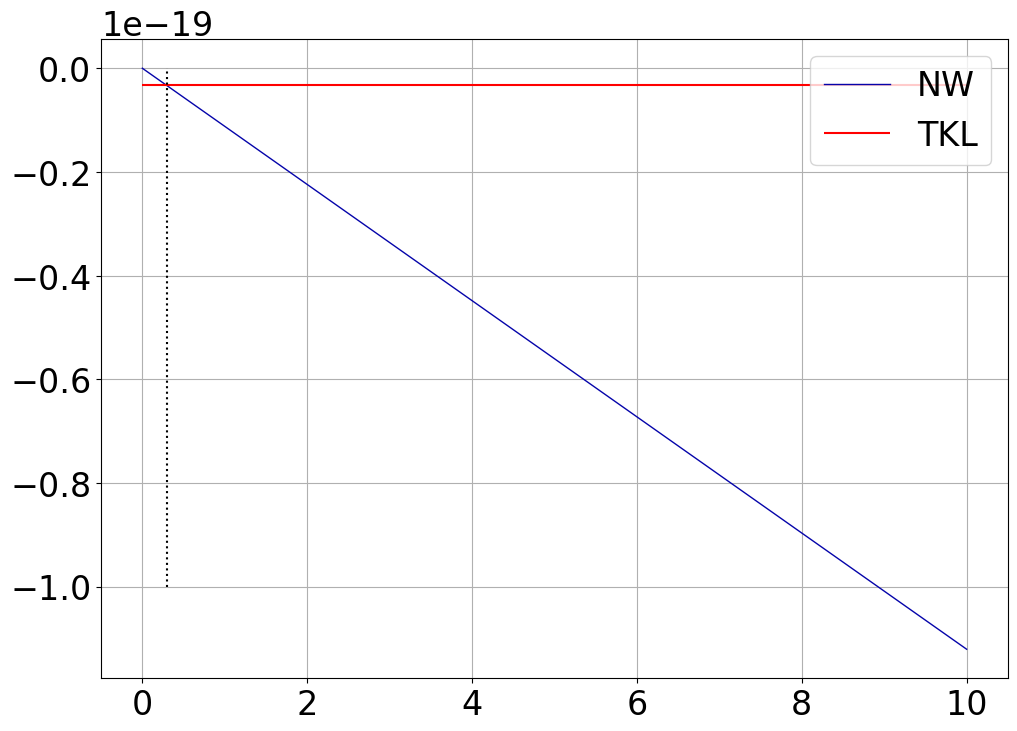

In [304]:
V_nw = np.linspace(0,10,100001)
print(np.diff(V_nw)[0])
A1, A2_tkl = a_tickle_vs_a_nw(5,1,V_nw)
# print(A1)
# print(A2_tkl)

figname = 'a_tkl_vs_a_nw'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

ax.plot(V_nw,A1,
    ls='-',lw=1,
    marker='',
    color='xkcd:royal blue', # royal blue
    label=f'NW')

ax.hlines(A2_tkl,V_nw[0],V_nw[-1],
    ls='-',color='r',
    label='TKL')

ax.legend()

ax.grid()

i_equal = np.argmin( np.abs(A2_tkl - A1) )
V_nw_equal = V_nw[i_equal]

print(V_nw_equal)

ax.vlines(V_nw_equal,-1e-19,0,
    ls=':',color='k',
    label='TKL')

In [432]:
detuning = np.array([-12.4])*Gamma_SP # -12.4
# detuning = (np.linspace(-25,0,25+1)[1::4] - 4)*Gamma_SP # (f_397 - f_397_Wan)*2*np.pi
f_397 = (detuning + f_397_Wan*2*np.pi)/2/np.pi
lam_397 = 299792458/f_397

print(detuning/Gamma_SP)
print(lam_397*1e9)

f_z = 422500
delta_f_z = 3500
shift_f_z = -500
f_t = np.linspace(f_z+shift_f_z -delta_f_z, f_z+shift_f_z +delta_f_z, 5001)

p_roots = np.zeros((len(lam_397),len(f_t),6))

# for i,j in enumerate(lam_397):
#     REIN = Duffing_analytical(V_tkl = V_tkl, V_nw = 0, V_piezo = 0,
#                         omega_z = f_z*2*math.pi, omega_t = f_t*2*math.pi,
#                         phi_nw = 0,
#                         B = None, # 1.24*1e18 *4*math.pi**2
#                         cooling_rate = None, nl_damping_rate = None,
#                         lam_397=j)

REIN = Duffing_analytical(V_tkl = 0.025, V_nw = 1, V_piezo = 5/4.512899038958427, #  *0.7343421052582553   *0.9577642276422764
                        omega_z = f_z*2*math.pi, omega_drive = f_t*2*math.pi,
                        phi_tkl = 0, phi_nw = 0,
                        B = -4.5e19,
                        cooling_rate = None, nl_damping_rate = None,
                        P397 = 75e-6, w397 = 120e-6, lam_397 = 396.959120e-9,
                        sweep_length = len(f_t))

    # REIN.set_params()
p_roots, sigma = REIN.find_roots()
phase = REIN.ss_phase(np.abs(p_roots))

[-12.4]
[396.9591195]
=== Initialise simulation ===
  --- Potential parameters ---
  omega_z = 2.655e+06
  omega_drive0  = 2.630e+06
  Pot : B = -4.50000e+19
  --- Coupling parameters ---
  V_tkl = 2.500e-02
  V_nw  = 1.000e+00
  V_piezo = 1.108e+00
  phi_tkl = 0.000e+00
  phi_nw  = 0.000e+00
  NW  : A1/m = -1.934e+05
  Tkl : A2/m = -1.934e+05
  --- Laser parameters ---
  Saturation = 1.47133e+01
  Detuning   = -1.24444e+01 Gamma
  Beta       = 2.87346e+04
  Gamma      = 3.60354e+02
  cooling_rate    = 7.20709e+02
  nl_damping_rate = 1.17688e-01
  Coefficients of the Taylor expansion for laser cooling
  Orders         0       1           2          3
          3.937e+04, -7.207e+02, 9.811e+00, -1.177e-01


In [429]:
print(REIN.sat0)
print(REIN.detuning/Gamma_SP)

14.713331193065416
-15.999999994204911


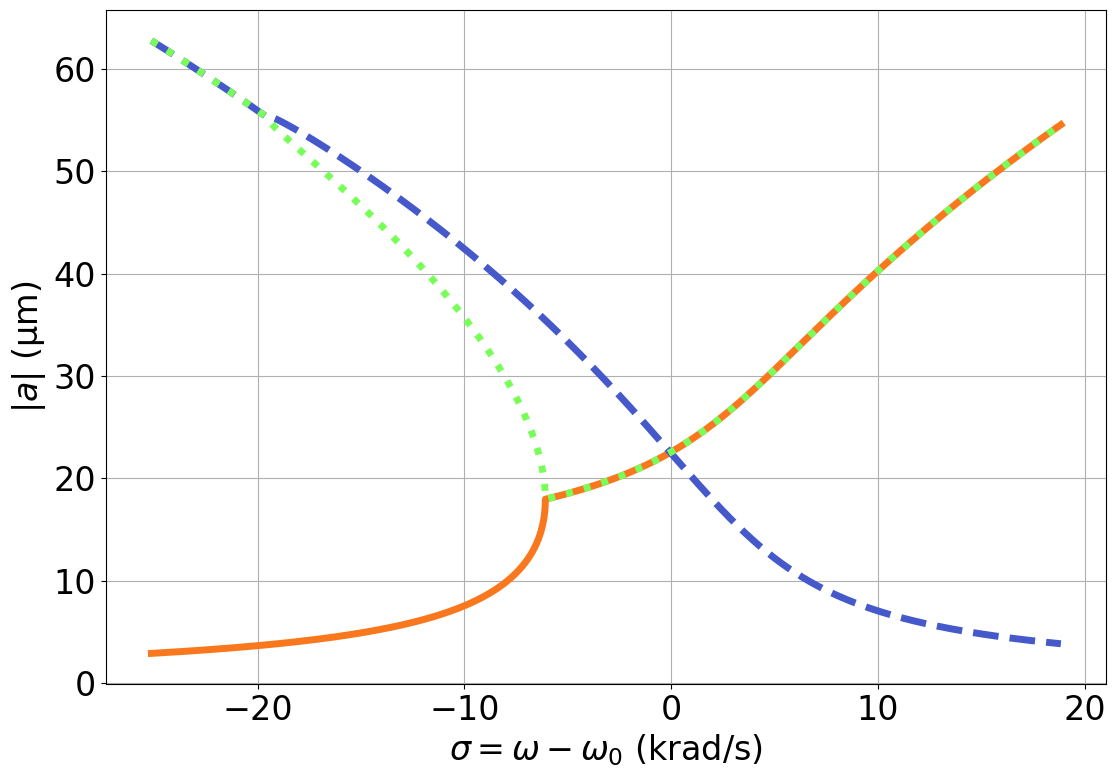

In [433]:
figname = 'Duffing_roots_vs_detuning'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

ax.plot(sigma[:]*1e-3,np.abs(p_roots[2])*1e6,
    ls='-',lw=5,
    color=cm(0.76), # royal blue
    marker='')

ax.plot(sigma[:]*1e-3,np.abs(p_roots[0])*1e6,
    ls='--',lw=5,
    color=cm(0.1), # royal blue
    marker='',
    label=f'{detuning/Gamma_SP}')

ax.plot(sigma[:]*1e-3,np.abs(p_roots[1])*1e6,
    ls=':',lw=5,
    color=cm(0.45), # royal blue
    marker='')

# ax.text(-5888,16.6,f'detuning : {detuning[0]/Gamma_SP:.3f} $\Gamma$')

ax.set_xlabel('$\\sigma = \omega - \omega_0$ (krad/s)')
ax.set_ylabel('$|a|$ (µm)')

ax.grid()
# ax.legend(title='Detuning ($-\Gamma$)')

# ax.set_xlim(-30000,30000)
# ax.set_ylim(-1,70)

plt.tight_layout()

plt.savefig(figname+'.png',dpi=300)

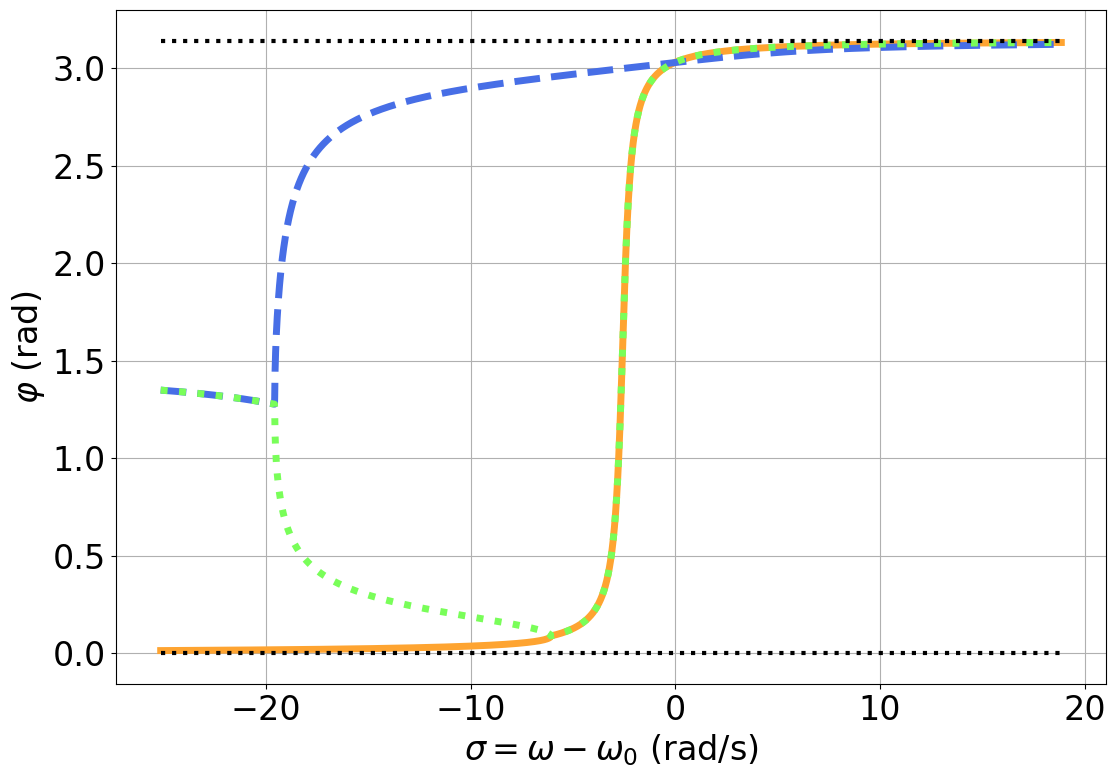

In [437]:
figname = 'Phase_vs_detuning'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

ax.plot(sigma[:]*1e-3,phase[2,:],
    ls='-',lw=5,
    color=cm(0.7), # royal blue
    marker='')

ax.plot(sigma[:]*1e-3,phase[0,:],
    ls='--',lw=5,
    color=cm(0.13), # royal blue
    marker='',
    label=f'')

ax.plot(sigma[:]*1e-3,phase[1,:],
    ls=':',lw=5,
    color=cm(0.45), # royal blue
    marker='')

ax.hlines(np.pi,np.min(sigma*1e-3),np.max(sigma*1e-3),
            ls=':',lw=3,
            color='k')
ax.hlines(0,np.min(sigma*1e-3),np.max(sigma*1e-3),
            ls=':',lw=3,
            color='k')

# ax.text(-5888,16.6,f'detuning : {detuning[0]/Gamma_SP:.3f} $\Gamma$')

ax.set_xlabel('$\\sigma = \omega - \omega_0$ (rad/s)')
ax.set_ylabel('$\\varphi$ (rad)')

ax.grid()
# ax.legend(title='Detuning ($-\Gamma$)')

# ax.set_xlim(0,2000)
# ax.set_ylim(-1,23)

plt.tight_layout()

plt.savefig(figname+'.png',dpi=300)

## Amplitude vs. laser detuning

In [339]:
detuning = np.linspace(-24,-8,5)*Gamma_SP
# detuning = (np.linspace(-25,0,25+1)[1::4] - 4)*Gamma_SP # (f_397 - f_397_Wan)*2*np.pi
print(detuning/Gamma_SP)
f_397 = (detuning + f_397_Wan*2*np.pi)/2/np.pi
lam_397 = 299792458/f_397

print(lam_397*1e9)

f_z = 422500
delta_f_z = 5000
shift_f_z = 0
f_t = np.linspace(f_z+shift_f_z -delta_f_z, f_z+shift_f_z +delta_f_z, 5001)

p_roots = np.zeros((len(lam_397),6,len(f_t)))

for i,j in enumerate(lam_397):
    REIN = Duffing_analytical(V_tkl = 0.025, V_nw = 1, V_piezo = 5/4.512899038958427, #  *0.7343421052582553   *0.9577642276422764
                        omega_z = f_z*2*math.pi, omega_drive = f_t*2*math.pi,
                        phi_tkl = 0, phi_nw = 0,
                        B = -4.5e19,
                        cooling_rate = None, nl_damping_rate = None,
                        P397 = 75e-6, w397 = 120e-6, lam_397 = j,
                        sweep_length = len(f_t))
    p_roots[i], _ = REIN.find_roots()

[-24. -20. -16. -12.  -8.]
[396.95925101 396.95920566 396.95916031 396.95911496 396.95906961]
=== Initialise simulation ===
=== Initialise simulation ===


/var/folders/75/jx9j_6b51pd1_6tgvbf8rjm80000gs/T/ipykernel_6340/399982623.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  p_roots[i], _ = REIN.find_roots()


=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===


0
1
2
3
4


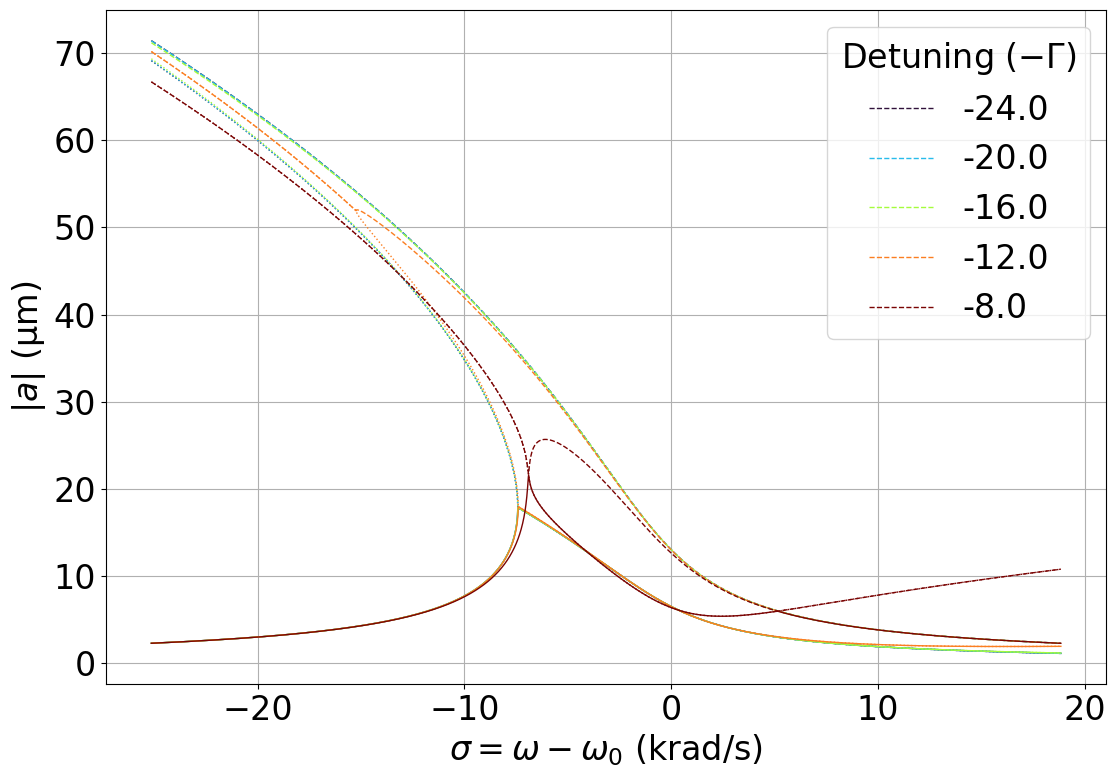

In [340]:
figname = 'Duffing_roots_vs_detuning'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

for i,j in enumerate(p_roots):
    print(i)
    ax.plot(sigma[:]*1e-3,np.abs(j[0])[:]*1e6,
        ls='--',lw=1,
        color=cm(i/(len(p_roots)-1)), # royal blue
        marker='',
        label=f'{detuning[i]/Gamma_SP}')

    ax.plot(sigma[:]*1e-3,np.abs(j[1])[:]*1e6,
        ls=':',lw=1,
        color=cm(i/(len(p_roots)-1)), # royal blue
        marker='')

    ax.plot(sigma[:]*1e-3,np.abs(j[2])[:]*1e6,
        ls='-',lw=1,
        color=cm(i/(len(p_roots)-1)), # royal blue
        marker='')

# i_min_1 = np.argmax(np.diff(p_roots[:,0]))
# i_min_2 = np.argmin(np.abs(p_roots[:,1]))

# print(i_min_1,i_min_2)

# ax.plot(sigma[:i_min_1],np.abs(p_roots[:,0])[:i_min_1]*1e6,
#     ls='-',lw=1,
#     color='C0', # royal blue
#     marker='',
#     label='')

# ax.plot(sigma[i_min_2:i_min_1+5],np.abs(p_roots[:,1])[i_min_2:i_min_1+5]*1e6,
#     ls=':',lw=1,
#     color='C0', # royal blue
#     marker='')

# ax.plot(sigma[i_min_2:],np.abs(p_roots[:,2])[i_min_2:]*1e6,
#     ls='-',lw=1,
#     color='C0', # royal blue
#     marker='')

ax.set_xlabel('$\\sigma = \omega - \omega_0$ (krad/s)')
ax.set_ylabel('$|a|$ (µm)')

ax.grid()
ax.legend(title='Detuning ($-\Gamma$)')

# ax.set_xlim(-3000,7000)
# ax.set_ylim(-1,35)

plt.tight_layout()

# plt.savefig(figname+'.png',dpi=300)

## Amplitude vs. laser power

In [341]:
P_397 = np.linspace(0,2000,11)[::1]*1e-6 # (f_397 - f_397_Wan)*2*np.pi
print(P_397)

detuning = -16*Gamma_SP
print(detuning/Gamma_SP)
f_397 = (detuning + f_397_Wan*2*np.pi)/2/np.pi
lam_397 = 299792458/f_397

print(lam_397*1e9)

f_z = 422500
delta_f_z = 5000
shift_f_z = 0
f_t = np.linspace(f_z+shift_f_z -delta_f_z, f_z+shift_f_z +delta_f_z, 5001)

p_roots = np.zeros((len(P_397),6,len(f_t)))

for i,j in enumerate(P_397):
    REIN = Duffing_analytical(V_tkl = 0.025, V_nw = 1, V_piezo = 5/4.512899038958427, #  *0.7343421052582553   *0.9577642276422764
                        omega_z = f_z*2*math.pi, omega_drive = f_t*2*math.pi,
                        phi_tkl = 0, phi_nw = 0,
                        B = -4.5e19,
                        cooling_rate = None, nl_damping_rate = None,
                        P397 = j, w397 = 120e-6, lam_397 = lam_397,
                        sweep_length = len(f_t))
    p_roots[i], _ = REIN.find_roots()

[0.     0.0002 0.0004 0.0006 0.0008 0.001  0.0012 0.0014 0.0016 0.0018
 0.002 ]
-16.0
396.95916031195105
=== Initialise simulation ===
=== Initialise simulation ===


/var/folders/75/jx9j_6b51pd1_6tgvbf8rjm80000gs/T/ipykernel_6340/3108338783.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  p_roots[i], _ = REIN.find_roots()


=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===


0
1
2
3
4
5
6
7
8
9
10


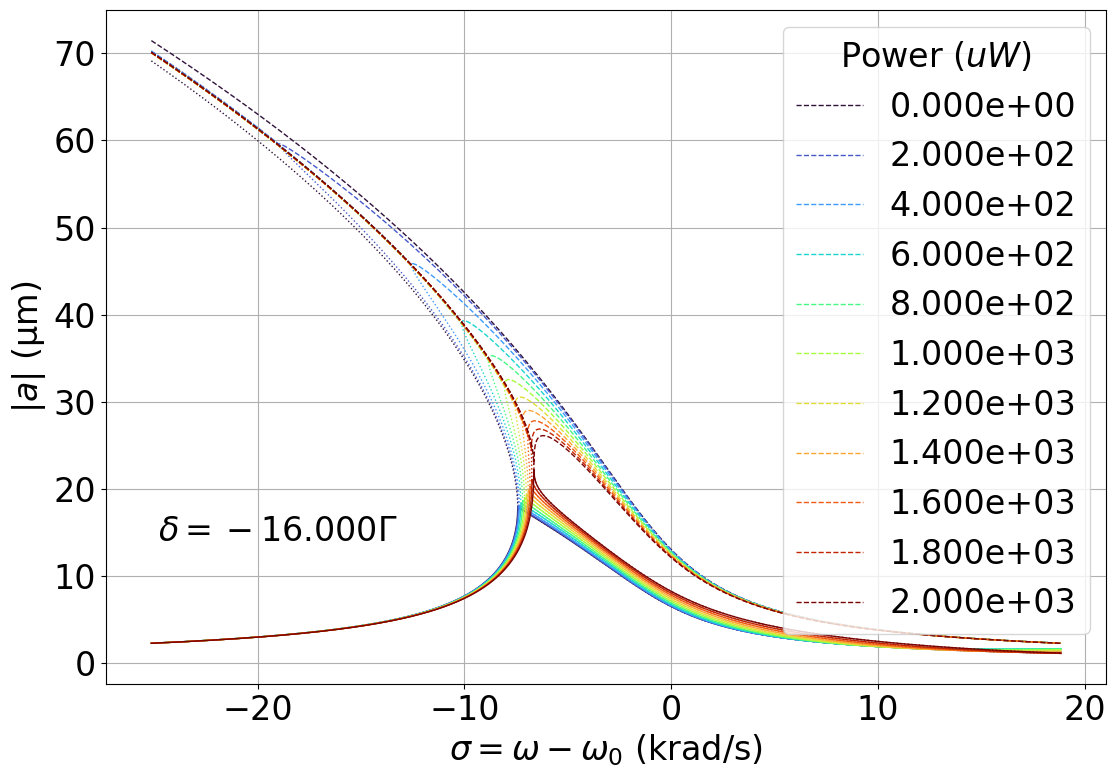

In [345]:
figname = 'Duffing_roots_vs_lasercool_-16G'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

for i,j in enumerate(p_roots):
    print(i)
    ax.plot(sigma[:]*1e-3,np.abs(j[0])[:]*1e6,
        ls='--',lw=1,
        color=cm(i/(len(p_roots)-1)), # royal blue
        marker='',
        label=f'{P_397[i]*1e6:.3e}')

    ax.plot(sigma[:]*1e-3,np.abs(j[1])[:]*1e6,
        ls=':',lw=1,
        color=cm(i/(len(p_roots)-1)), # royal blue
        marker='')

    ax.plot(sigma[:]*1e-3,np.abs(j[2])[:]*1e6,
        ls='-',lw=1,
        color=cm(i/(len(p_roots)-1)), # royal blue
        marker='')

ax.text(-19,14,f'$\delta = {detuning/Gamma_SP:.3f}\Gamma $',ha='center')

# i_min_1 = np.argmax(np.diff(p_roots[:,0]))
# i_min_2 = np.argmin(np.abs(p_roots[:,1]))

# print(i_min_1,i_min_2)

# ax.plot(sigma[:i_min_1],np.abs(p_roots[:,0])[:i_min_1]*1e6,
#     ls='-',lw=1,
#     color='C0', # royal blue
#     marker='',
#     label='')

# ax.plot(sigma[i_min_2:i_min_1+5],np.abs(p_roots[:,1])[i_min_2:i_min_1+5]*1e6,
#     ls=':',lw=1,
#     color='C0', # royal blue
#     marker='')

# ax.plot(sigma[i_min_2:],np.abs(p_roots[:,2])[i_min_2:]*1e6,
#     ls='-',lw=1,
#     color='C0', # royal blue
#     marker='')

ax.set_xlabel('$\\sigma = \omega - \omega_0$ (krad/s)')
ax.set_ylabel('$|a|$ (µm)')

ax.grid()
ax.legend(title='Power ($uW$)')

# ax.set_xlim(-5000,5000)
# ax.set_ylim(-1,25)

plt.tight_layout()

# plt.savefig(figname+'.png',dpi=300)

## Amplitude vs. drive amplitude

With power and detuning choosen so the feature could be seen in REIN

In [346]:
P_397 = 75*1e-6 # (f_397 - f_397_Wan)*2*np.pi
print(P_397)

detuning = -16*Gamma_SP
print(detuning/Gamma_SP)
f_397 = (detuning + f_397_Wan*2*np.pi)/2/np.pi
lam_397 = 299792458/f_397

print(lam_397*1e9)

f_z = 422500
delta_f_z = 5000
shift_f_z = 0
f_t = np.linspace(f_z+shift_f_z -delta_f_z, f_z+shift_f_z +delta_f_z, 5001)

V_tkl = np.linspace(0,0.1,11)

p_roots = np.zeros((len(V_tkl),6,len(f_t)))

k_tkl = []
for i,j in enumerate(V_tkl):
    REIN = Duffing_analytical(V_tkl = j, V_nw = 1, V_piezo = 5/4.512899038958427, #  *0.7343421052582553   *0.9577642276422764
                        omega_z = f_z*2*math.pi, omega_drive = f_t*2*math.pi,
                        phi_tkl = 0, phi_nw = 0,
                        B = -4.5e19,
                        cooling_rate = None, nl_damping_rate = None,
                        P397 = P_397, w397 = 120e-6, lam_397 = lam_397,
                        sweep_length = len(f_t))
    p_roots[i], _ = REIN.find_roots()
    k_tkl.append(REIN.A2/m_Ca)

7.5e-05
-16.0
396.95916031195105
=== Initialise simulation ===
=== Initialise simulation ===


/var/folders/75/jx9j_6b51pd1_6tgvbf8rjm80000gs/T/ipykernel_6340/3200579444.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  p_roots[i], _ = REIN.find_roots()


=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===
=== Initialise simulation ===


0
1
2
3
4
5
6
7
8
9
10


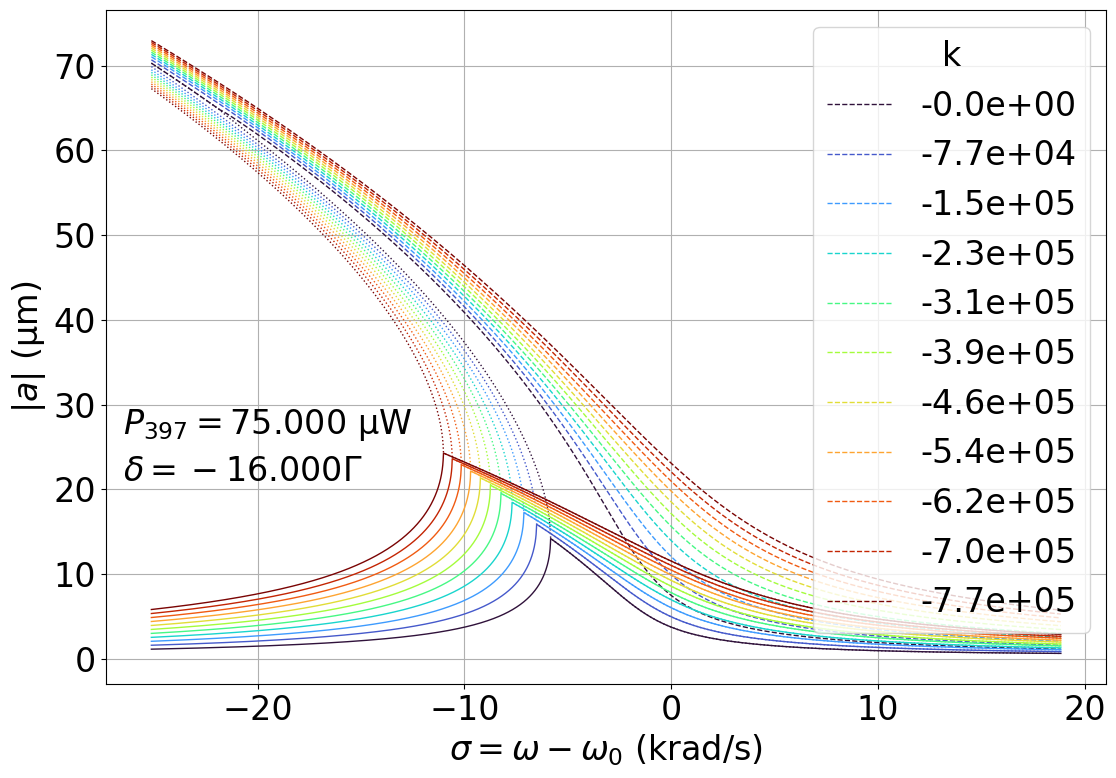

In [354]:
figname = 'Duffing_roots_vs_k'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

for i,j in enumerate(p_roots):
    print(i)
    ax.plot(sigma[:]*1e-3,np.abs(j[0])[:]*1e6,
        ls='--',lw=1,
        color=cm(i/(len(p_roots)-1)), # royal blue
        marker='',
        label=f'{k_tkl[i]:.1e}')

    ax.plot(sigma[:]*1e-3,np.abs(j[1])[:]*1e6,
        ls=':',lw=1,
        color=cm(i/(len(p_roots)-1)), # royal blue
        marker='')

    ax.plot(sigma[:]*1e-3,np.abs(j[2])[:]*1e6,
        ls='-',lw=1,
        color=cm(i/(len(p_roots)-1)), # royal blue
        marker='')

ax.text(-26.5,26.5,f'$P_{{397}} = {P_397*1e6:.3f}$ µW',ha='left')
ax.text(-26.5,21,f'$\delta = {detuning/Gamma_SP:.3f}\Gamma $',ha='left')

# i_min_1 = np.argmax(np.diff(p_roots[:,0]))
# i_min_2 = np.argmin(np.abs(p_roots[:,1]))

# print(i_min_1,i_min_2)

# ax.plot(sigma[:i_min_1],np.abs(p_roots[:,0])[:i_min_1]*1e6,
#     ls='-',lw=1,
#     color='C0', # royal blue
#     marker='',
#     label='')

# ax.plot(sigma[i_min_2:i_min_1+5],np.abs(p_roots[:,1])[i_min_2:i_min_1+5]*1e6,
#     ls=':',lw=1,
#     color='C0', # royal blue
#     marker='')

# ax.plot(sigma[i_min_2:],np.abs(p_roots[:,2])[i_min_2:]*1e6,
#     ls='-',lw=1,
#     color='C0', # royal blue
#     marker='')

ax.set_xlabel('$\\sigma = \omega - \omega_0$ (krad/s)')
ax.set_ylabel('$|a|$ (µm)')

ax.grid()
ax.legend(title='k')

# ax.set_xlim(-3500,6500)
# ax.set_ylim(-1,31)

plt.tight_layout()

# plt.savefig(figname+'.png',dpi=300)

## Amplitude vs. other parameters

### HO + drive only

Vary drive.

=== Initialise simulation ===
01th arg. = V_tkl = has wrong length 5001 rather than 21 !


/var/folders/75/jx9j_6b51pd1_6tgvbf8rjm80000gs/T/ipykernel_6340/1875365949.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  self.dt = 2*math.pi/(self.n_dt*self.omega_z) # Interpolation time-step duration


AttributeError: 'Duffing_analytical' object has no attribute 'set_params'

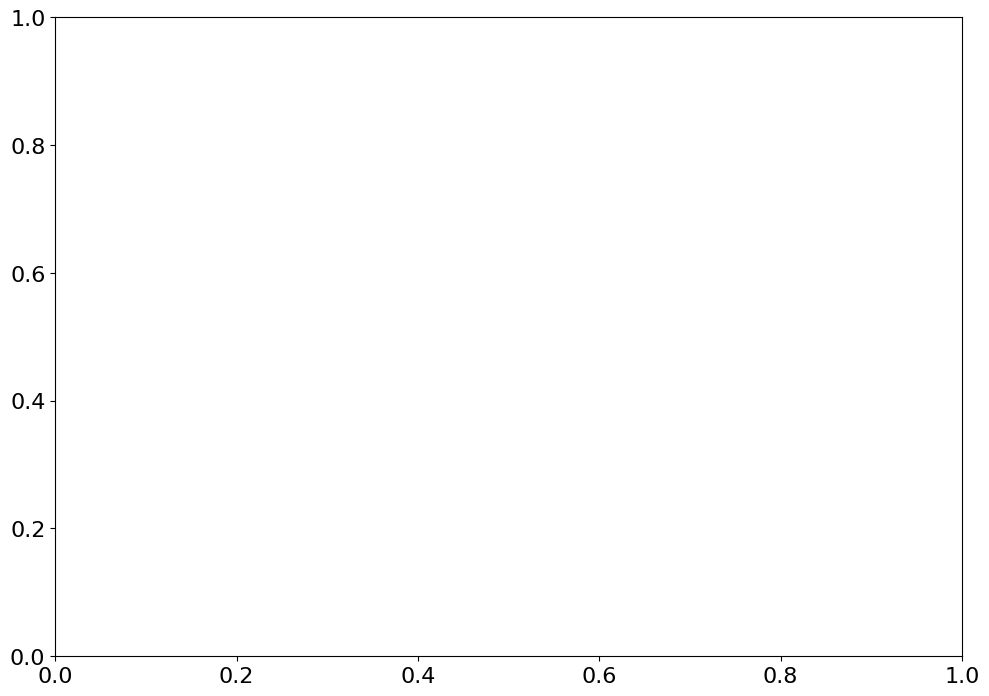

In [153]:
my_ls = ['-','--',':','-','--',':']

figname = 'amplitude_1'
fig, ax = plt.subplots(1,num=figname,clear=True,sharex=True)

sigma = np.linspace(-2000*2*np.pi,4000*2*np.pi,5001)

V_tkl_factor = 5
B = 1.24*1e18 *4*np.pi**2 *0
cooling_rate = 2*28 *2*np.pi *0
nl_damping_rate = 0.03566372451203145 *0
var_k = Duffing_analytical(sigma,
                           V_tkl_factor,
                           B,
                           cooling_rate,
                           nl_damping_rate)
                           
var_k.set_params()
p_roots, sigma = var_k.find_roots()

for k in range(len(p_roots[0])):
    ax.plot(sigma*1e-3 +422.5,np.abs(p_roots[:,k])*1e6,
        ls='', # my_ls[k]
        marker='.',
        label=f'{k}')

ax.text(410.1,15,
        f'k = {var_k.A2_tkl/m_Ca:.3e}\n$\\alpha$ = {B:.3e}\n$\mu$ = {cooling_rate:.3e}\n$\gamma$ = {nl_damping_rate:.3e}',
        bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 1, 1),
                   ))

ax.grid()

# ax.set_xlim(422.5-16,422.5+16)
# ax.set_ylim(-10,2500)

ax.set_xlabel(r'$\sigma = \omega_t - \omega_z$ [kHz]')
ax.set_ylabel('$a$ [µm]')

# plt.savefig(figname+'.png',dpi=300)

In [ ]:
my_ls = ['-','--',':']

figname = 'Duffing_a_vs_k'
fig, ax = plt.subplots(5,num=figname,clear=True,sharex=True)

sigma = np.linspace(-2000*2*np.pi,4000*2*np.pi,5001)
V_tkl_factor = np.array([1, 10, 20, 50, 100])
B = 1.24*1e18 *4*np.pi**2 *0
cooling_rate = 2*28 *2*np.pi *0
nl_damping_rate = 0.03566372451203145 *0
for i,j in enumerate(V_tkl_factor):
    var_k = Duffing_analytical(sigma,
                            j,
                            B,
                            cooling_rate,
                            nl_damping_rate)
    var_k.set_params()
    p_roots, sigma = var_k.find_roots()

    # for k in range(3):
    #     ax[i].plot(sigma,np.abs(p_roots[:,k])*1e6,
    #         ls=my_ls[k],
    #         marker='',
    #         label=f'{k}')
        
    for k in range(len(p_roots[0])):
        ax[i].plot(sigma*1e-3 +422.5,np.abs(p_roots[:,k])*1e6,
            ls='', # my_ls[k]
            marker='.',ms=0.5,
            label=f'{k}')
        
    ax[i].text(0.025,0.25,
    f'k = {var_k.A2_tkl/m_Ca:.3e}\n$\\alpha$ = {B:.3e}\n$\mu$ = {cooling_rate:.3e}\n$\gamma$ = {nl_damping_rate:.3e}',
        fontsize=12,
        transform = ax[i].transAxes,
        bbox=dict(boxstyle="round",
                ec=(1., 0.5, 0.5),
                fc=(1., 1, 1),
                ))

    ax[i].grid()

    ax[i].set_xlim(422.5-16,422.5+16)

plt.savefig(figname+'.png',dpi=300)

### HO + anharmonicity + drive

Vary anharmonicity.

In [ ]:
my_ls = ['-','--',':']

figname = 'Duffing_a_vs_B'
fig, ax = plt.subplots(5,num=figname,clear=True,sharex=True)

sigma = np.linspace(-2000*2*np.pi,4000*2*np.pi,5001)
V_tkl_factor = 5
B = 1.24*1e18 *4*np.pi**2 * np.array([1, 10, 20, 50, 100])
cooling_rate = 2*28 *2*np.pi *0
nl_damping_rate = 0.03566372451203145 *0
for i,j in enumerate(B):
    var_k = Duffing_analytical(sigma,
                            V_tkl_factor,
                            j,
                            cooling_rate,
                            nl_damping_rate)

    var_k.set_params()
    p_roots, sigma = var_k.find_roots()

    # for k in range(3):
    #     ax[i].plot(sigma,np.abs(p_roots[:,k])*1e6,
    #         ls=my_ls[k],
    #         marker='',
    #         label=f'{k}')
        
    for k in range(len(p_roots[0])):
        ax[i].plot(sigma*1e-3 +422.5,np.abs(p_roots[:,k])*1e6,
            ls='', # my_ls[k]
            marker='.',ms=0.5,
            label=f'{k}')

    ax[i].text(0.025,0.25,
    f'k = {var_k.A2_tkl/m_Ca:.3e}\n$\\alpha$ = {var_k.B:.3e}\n$\mu$ = {var_k.cooling_rate:.3e}\n$\gamma$ = {var_k.nl_damping_rate:.3e}',
        fontsize=12,
        transform = ax[i].transAxes,
        bbox=dict(boxstyle="round",
                ec=(1., 0.5, 0.5),
                fc=(1., 1, 1),
                ))

    ax[i].grid()

    ax[i].set_xlim(422.5-16,422.5+16)

# plt.savefig(figname+'.png',dpi=300)

### HO + anharmonicity + cooling_rate + drive

Vary cooling_rate.

In [ ]:
my_ls = ['-','--',':']

figname = 'Duffing_a_vs_cooling_rate'
fig, ax = plt.subplots(5,num=figname,clear=True,sharex=True)

sigma = np.linspace(-2000*2*np.pi,4000*2*np.pi,5001)
V_tkl_factor = 5
B = 1.24*1e18 *4*np.pi**2
cooling_rate = 2*28 *2*np.pi * np.array([1, 2,3,4,5])
nl_damping_rate = 0.03566372451203145 * 0
for i,j in enumerate(cooling_rate):
    var_k = Duffing_analytical(sigma,
                            V_tkl_factor,
                            B,
                            j,
                            nl_damping_rate)
    var_k.set_params()
    p_roots, sigma = var_k.find_roots()

    # for k in range(3):
    #     ax[i].plot(sigma,np.abs(p_roots[:,k])*1e6,
    #         ls=my_ls[k],
    #         marker='',
    #         label=f'{k}')
        
    for k in range(len(p_roots[0])):
        ax[i].plot(sigma*1e-3 +422.5,np.abs(p_roots[:,k])*1e6,
            ls='', # my_ls[k]
            marker='.',ms=0.5,
            label=f'{k}')

    ax[i].text(0.025,0.25,
    f'k = {var_k.A2_tkl/m_Ca:.3e}\n$\\alpha$ = {var_k.B:.3e}\n$\\mu$ = {var_k.cooling_rate:.3e}\n$\\gamma$ = {var_k.nl_damping_rate:.3e}',
        fontsize=12,
        transform = ax[i].transAxes,
        bbox=dict(boxstyle="round",
                ec=(1., 0.5, 0.5),
                fc=(1., 1, 1),
                ))

    ax[i].grid()


    ax[i].set_xlim(422.5-16,422.5+16)
    ax[i].set_ylim(-1,50)

# plt.savefig(figname+'.png',dpi=300)

### HO + anharmonicity + cooling_rate + nl_damping_rate + drive

Vary nl_damping_rate.

In [ ]:
my_ls = ['-','--',':']

figname = 'Duffing_a_vs_nl_damping_rate'
fig, ax = plt.subplots(5,num=figname,clear=True,sharex=True)

sigma = np.linspace(-2000*2*np.pi,4000*2*np.pi,5001)
V_tkl_factor = 5
B = 1.24*1e18 *4*np.pi**2
cooling_rate = 2*28 *2*np.pi 
nl_damping_rate = 0.03566372451203145 * np.array([1,10,20,50,100])
for i,j in enumerate(nl_damping_rate):
    var_k = Duffing_analytical(sigma,
                            V_tkl_factor,
                            B,
                            cooling_rate,
                            j)
    var_k.set_params()
    p_roots, sigma = var_k.find_roots()

    # for k in range(3):
    #     ax[i].plot(sigma,np.abs(p_roots[:,k])*1e6,
    #         ls=my_ls[k],
    #         marker='',
    #         label=f'{k}')
        
    for k in range(len(p_roots[0])):
        ax[i].plot(sigma*1e-3 +422.5,np.abs(p_roots[:,k])*1e6,
            ls='', # my_ls[k]
            marker='.',ms=0.5,
            label=f'{k}')

    ax[i].text(0.025,0.25,
    f'k = {var_k.A2_tkl/m_Ca:.3e}\n$\\alpha$ = {var_k.B:.3e}\n$\\mu$ = {var_k.cooling_rate:.3e}\n$\\gamma$ = {var_k.nl_damping_rate:.3e}',
        fontsize=12,
        transform = ax[i].transAxes,
        bbox=dict(boxstyle="round",
                ec=(1., 0.5, 0.5),
                fc=(1., 1, 1),
                ))

    ax[i].grid()


    ax[i].set_xlim(422.5-16,422.5+16)
    ax[i].set_ylim(-1,28)

# plt.savefig(figname+'.png',dpi=300)

### HO + cooling_rate + nl_damping_rate + drive

No anharmonicity, vary cooling_rate.

In [ ]:
my_ls = ['-','--',':']

figname = 'Duffing_a_vs_cooling_rate_anharmonicity'
fig, ax = plt.subplots(5,num=figname,clear=True,sharex=True)

sigma = np.linspace(-2000*2*np.pi,4000*2*np.pi,5001)
V_tkl_factor = 5
B = 1.24*1e18 *4*np.pi**2
cooling_rate = 2*28 *2*np.pi * np.array([1,2,3,4,5])
nl_damping_rate = 0.03566372451203145
for i,j in enumerate(cooling_rate):
    var_k = Duffing_analytical(sigma,
                            V_tkl_factor,
                            B,
                            j,
                            nl_damping_rate)
    var_k.set_params()
    p_roots, sigma = var_k.find_roots()

    # for k in range(3):
    #     ax[i].plot(sigma,np.abs(p_roots[:,k])*1e6,
    #         ls=my_ls[k],
    #         marker='',
    #         label=f'{k}')
        
    for k in range(len(p_roots[0])):
        ax[i].plot(sigma*1e-3 +422.5,np.abs(p_roots[:,k])*1e6,
            ls='', # my_ls[k]
            marker='.',ms=0.5,
            label=f'{k}')

    ax[i].text(0.025,0.25,
    f'k = {var_k.A2_tkl/m_Ca:.3e}\n$\\alpha$ = {var_k.B:.3e}\n$\\mu$ = {var_k.cooling_rate:.3e}\n$\\gamma$ = {var_k.nl_damping_rate:.3e}',
        fontsize=12,
        transform = ax[i].transAxes,
        bbox=dict(boxstyle="round",
                ec=(1., 0.5, 0.5),
                fc=(1., 1, 1),
                ))

    ax[i].grid()


    ax[i].set_xlim(422.5-16,422.5+16)
    ax[i].set_ylim(-1,28)

ax[2].set_ylabel('$a$ (µm)')
ax[-1].set_xlabel('$f_t$ (kHz)')

plt.tight_layout()

plt.savefig(figname+'.png',dpi=300)

In [ ]:
my_ls = ['-','--',':']

figname = 'Duffing_a_vs_cooling_rate_noanharmonicity'
fig, ax = plt.subplots(5,num=figname,clear=True,sharex=True)

sigma = np.linspace(-2000*2*np.pi,4000*2*np.pi,5001)
V_tkl_factor = 5
B = 1.24*1e18 *4*np.pi**2
cooling_rate = 2*28 *2*np.pi * np.array([1,2,3,4,5])
nl_damping_rate = 0.03566372451203145
for i,j in enumerate(cooling_rate):
    var_k = Duffing_analytical(sigma,
                            V_tkl_factor,
                            B,
                            j,
                            nl_damping_rate)
    var_k.set_params()
    p_roots, sigma = var_k.find_roots()

    # for k in range(3):
    #     ax[i].plot(sigma,np.abs(p_roots[:,k])*1e6,
    #         ls=my_ls[k],
    #         marker='',
    #         label=f'{k}')
        
    for k in range(len(p_roots[0])):
        ax[i].plot(sigma*1e-3 +422.5,np.abs(p_roots[:,k])*1e6,
            ls='', # my_ls[k]
            marker='.',ms=0.5,
            label=f'{k}')

    ax[i].text(0.025,0.25,
    f'k = {var_k.A2_tkl/m_Ca:.3e}\n$\\alpha$ = {var_k.B:.3e}\n$\\mu$ = {var_k.cooling_rate:.3e}\n$\\gamma$ = {var_k.nl_damping_rate:.3e}',
        fontsize=12,
        transform = ax[i].transAxes,
        bbox=dict(boxstyle="round",
                ec=(1., 0.5, 0.5),
                fc=(1., 1, 1),
                ))

    ax[i].grid()


    ax[i].set_xlim(422.5-16,422.5+16)
    ax[i].set_ylim(-1,28)

ax[2].set_ylabel('$a$ (µm)')
ax[-1].set_xlabel('$f_t$ (kHz)')

plt.tight_layout()

plt.savefig(figname+'.png',dpi=300)

In [ ]:
my_ls = ['-','--',':']

figname = 'amplitude_vs_k'
fig, ax = plt.subplots(1,num=figname,clear=True,sharex=True)

V_tkl_factor = 5
var_k = Duffing_analytical(V_tkl_factor,7500)
var_k.set_params()
p_roots, sigma = var_k.find_foots()


ax.plot(sigma[:750]*1e-3 +422.5,np.abs(p_roots[:,0])[:750]*1e6,
    ls='-',lw=3,
    color='xkcd:dark blue', # royal blue
    marker='')

ax.plot(sigma[600:753]*1e-3 +422.5,np.abs(p_roots[:,1])[600:753]*1e6,
    ls='-',lw=3,
    color='xkcd:dark blue', # royal blue
    marker='')

ax.plot(sigma[506:]*1e-3 +422.5,np.abs(p_roots[:,2])[506:]*1e6,
    ls='-',lw=3,
    color='xkcd:dark blue', # royal blue
    marker='')

# ax.grid()

# ax.set_xlabel('$\sigma = \omega_t - \omega_z$ [kHz]')
# ax.set_ylabel('$a$ [µm]')

# plt.savefig(figname+'.png',dpi=300)

# Oscillator parameters

In [463]:
P_397 = 75*1e-6 # (f_397 - f_397_Wan)*2*np.pi
print(P_397)
detuning = -16*Gamma_SP
print(detuning/Gamma_SP)
f_397 = (detuning + f_397_Wan*2*np.pi)/2/np.pi
lam_397 = 299792458/f_397

print(lam_397*1e9)

f_z = 422500
delta_f_z = 5000
shift_f_z = 0
f_t = np.linspace(f_z+shift_f_z -delta_f_z, f_z+shift_f_z +delta_f_z, 5001)

V_tkl = 0.025 #85

p_roots = np.zeros((6,len(f_t)))

B = -4.5e19
assym = 1e9

REIN = Duffing_analytical(V_tkl = V_tkl, V_nw = 1, V_piezo = 5/4.512899038958427, #  *0.7343421052582553   *0.9577642276422764
                    omega_z = f_z*2*math.pi, omega_drive = f_t*2*math.pi,
                    phi_tkl = 0, phi_nw = 0,
                    B = B, assym = assym,
                    cooling_rate = None, nl_damping_rate = None,
                    P397 = P_397, w397 = 120e-6, lam_397 = lam_397,
                    sweep_length = len(f_t))

p_roots, sigma = REIN.find_roots()
delta_x0, delta_omega = REIN.shifts(np.abs(p_roots),B,assym)

7.5e-05
-16.0
396.95916031195105
=== Initialise simulation ===
  --- Potential parameters ---
  omega_z = 2.655e+06
  omega_drive0  = 2.623e+06
  Pot : B = -4.50000e+19
  --- Coupling parameters ---
  V_tkl = 2.500e-02
  V_nw  = 1.000e+00
  V_piezo = 1.108e+00
  phi_tkl = 0.000e+00
  phi_nw  = 0.000e+00
  NW  : A1/m = -1.934e+05
  Tkl : A2/m = -1.934e+05
  --- Laser parameters ---
  Saturation = 1.47133e+01
  Detuning   = -1.60000e+01 Gamma
  Beta       = 1.37879e+04
  Gamma      = 1.72911e+02
  cooling_rate    = 3.45822e+02
  nl_damping_rate = 3.51972e-02
  Coefficients of the Taylor expansion for laser cooling
  Orders         0       1           2          3
          2.405e+04, -3.458e+02, 3.710e+00, -3.520e-02


Text(0, 0.5, '$\\Delta x_0$ [µm]')

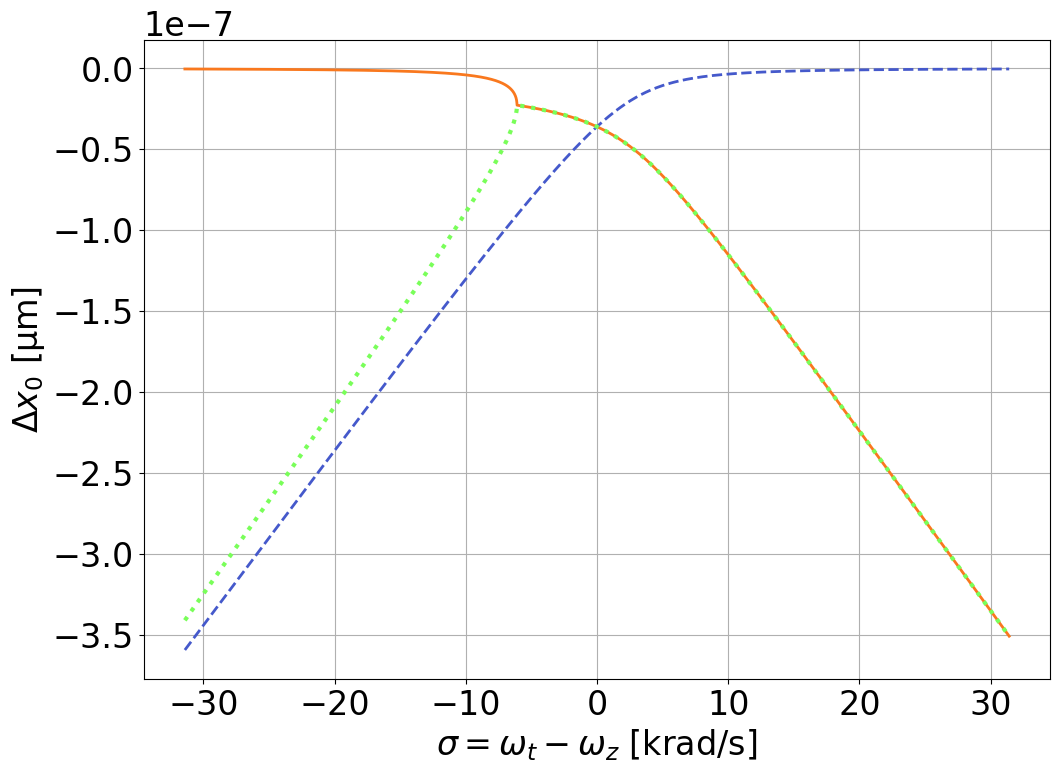

In [455]:
my_ls = ['-','--',':']

figname = 'deltax0_vs_ft'
fig, ax = plt.subplots(1,num=figname,clear=True,sharex=True)

ax.plot(sigma[:]*1e-3,delta_x0[2]*1e6,
    ls='-',lw=2,
    color=cm(0.76), # royal blue
    marker='')

ax.plot(sigma[:]*1e-3,delta_x0[0]*1e6,
    ls='--',lw=2,
    color=cm(0.1), # royal blue
    marker='',
    label=f'{detuning/Gamma_SP}')

ax.plot(sigma[:]*1e-3,delta_x0[1]*1e6,
    ls=':',lw=3,
    color=cm(0.45), # royal blue
    marker='')

ax.grid()

ax.set_xlabel('$\sigma = \omega_t - \omega_z$ [krad/s]')
ax.set_ylabel('$\Delta x_0$ [µm]')

# plt.savefig(figname+'.png',dpi=300)

Text(0, 0.5, '$\\Delta \\omega_0$ [krad/s]')

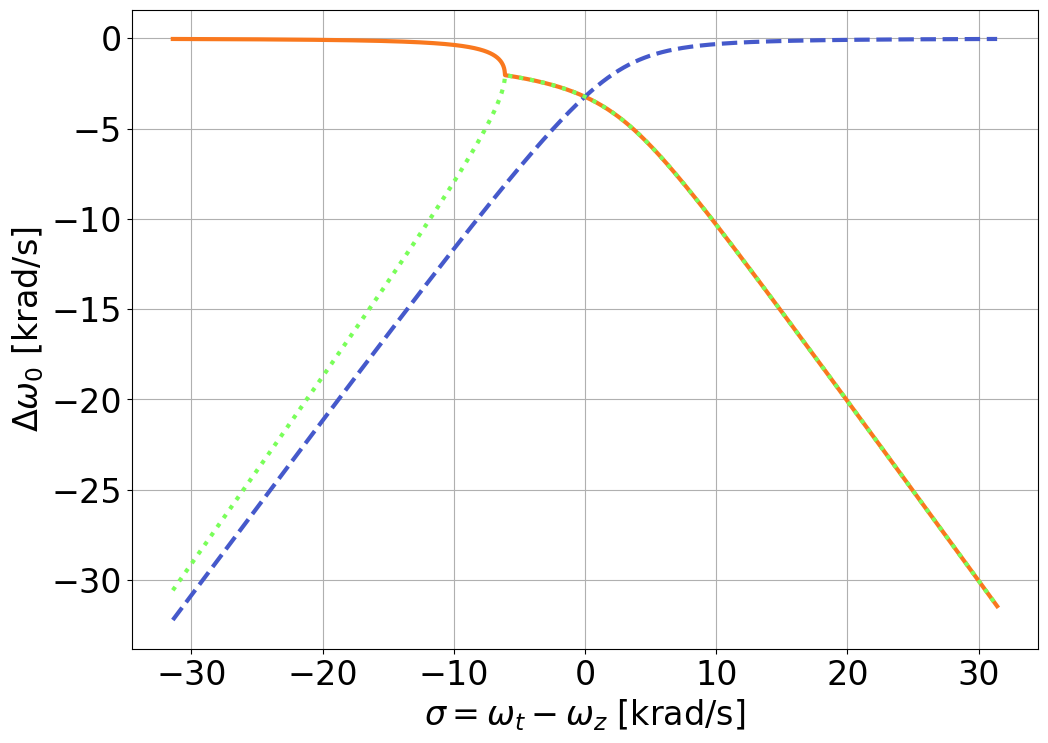

In [456]:
my_ls = ['-','--',':']

figname = 'deltaomega0_vs_ft'
fig, ax = plt.subplots(1,num=figname,clear=True,sharex=True)

ax.plot(sigma[:]*1e-3,delta_omega[2]*1e-3,
    ls='-',lw=3,
    color=cm(0.76), # royal blue
    marker='')

ax.plot(sigma[:]*1e-3,delta_omega[0]*1e-3,
    ls='--',lw=3,
    color=cm(0.1), # royal blue
    marker='',
    label=f'{detuning/Gamma_SP}')

ax.plot(sigma[:]*1e-3,delta_omega[1]*1e-3,
    ls=':',lw=3,
    color=cm(0.45), # royal blue
    marker='')

# ax.plot(sigma[:],delta_omega[2+3],
#     ls='-',lw=2,
#     color=cm(0.76), # royal blue
#     marker='')

# ax.plot(sigma[:],delta_omega[0+3],
#     ls='--',lw=2,
#     color=cm(0.1), # royal blue
#     marker='',
#     label=f'{detuning/Gamma_SP}')

# ax.plot(sigma[:],delta_omega[1+3],
#     ls=':',lw=3,
#     color=cm(0.45), # royal blue
#     marker='')

ax.grid()

ax.set_xlabel('$\sigma = \omega_t - \omega_z$ [krad/s]')
ax.set_ylabel('$\Delta \omega_0$ [krad/s]')

# plt.savefig(figname+'.png',dpi=300)

[-3.82351955e-16 -3.82659016e-16 -3.82966448e-16 ... -3.50715084e-13
 -3.50855021e-13 -3.50994959e-13]
3572
50.01803453050609
-1.775047932899493e-07


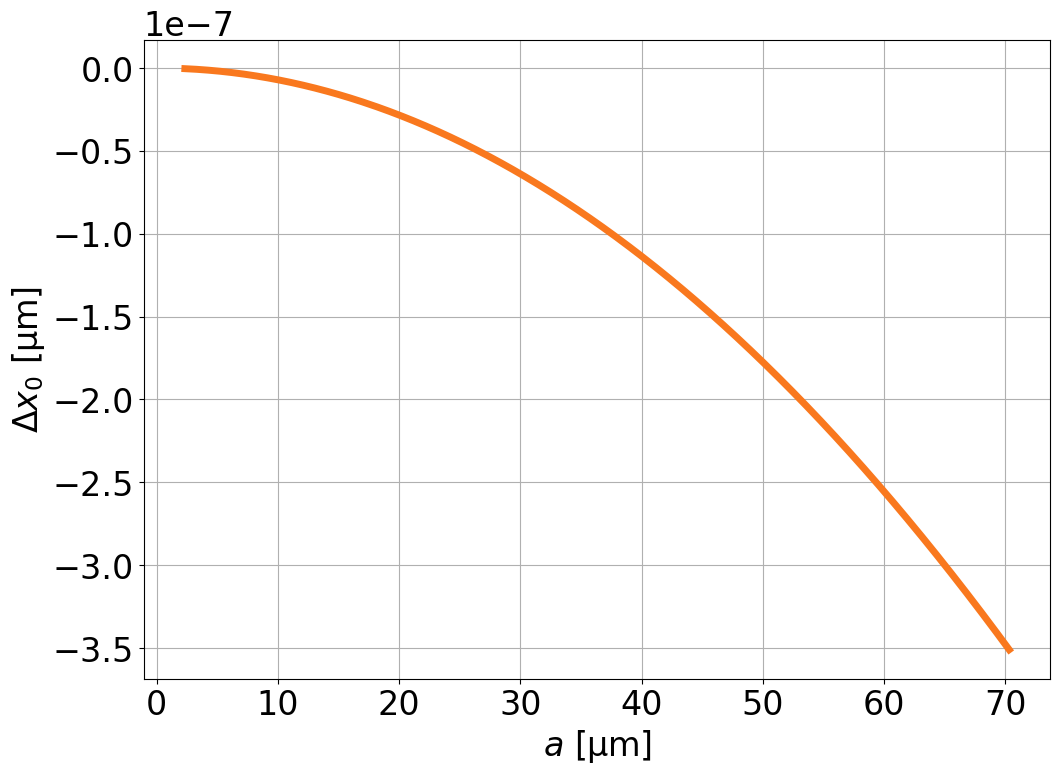

In [477]:
my_ls = ['-','--',':']

figname = 'deltax0_vs_a'
fig, ax = plt.subplots(1,num=figname,clear=True,sharex=True)

ax.plot(np.abs(p_roots[2])*1e6,delta_x0[2]*1e6,
    ls='-',lw=5,
    color=cm(0.76), # royal blue
    marker='')

# ax.plot(np.abs(p_roots[0])*1e6,delta_x0[0]*1e6,
#     ls='--',lw=3,
#     color=cm(0.1), # royal blue
#     marker='',
#     label=f'{detuning/Gamma_SP}')

# ax.plot(np.abs(p_roots[1])*1e6,delta_x0[1]*1e6,
#     ls=':',lw=3,
#     color=cm(0.45), # royal blue
#     marker='')

# ax.plot(p_roots[3]*1e6,delta_x0[2]*1e6,
#     ls='-',lw=2,
#     color=cm(0.76), # royal blue
#     marker='')

# ax.plot(p_roots[5]*1e6,delta_x0[0]*1e6,
#     ls='--',lw=2,
#     color=cm(0.1), # royal blue
#     marker='',
#     label=f'{detuning/Gamma_SP}')

# ax.plot(p_roots[4]*1e6,delta_x0[1]*1e6,
#     ls=':',lw=3,
#     color=cm(0.45), # royal blue
#     marker='')


ax.grid()

ax.set_xlabel('$a$ [µm]')
ax.set_ylabel('$\Delta x_0$ [µm]')

# plt.savefig(figname+'.png',dpi=300)
delta_x0_2 = delta_x0[2]
print(delta_x0_2)
index = int( len(delta_x0_2)*50/70 )
print(index)
print(np.abs(p_roots[2])[index+183]*1e6)
print(delta_x0_2[index+183]*1e6)

[   -34.25655404    -34.28406497    -34.31160913 ... -31422.07084832
 -31434.60843821 -31447.14606077]
3572
5.0018034530506094e-05
-15903.416900833734


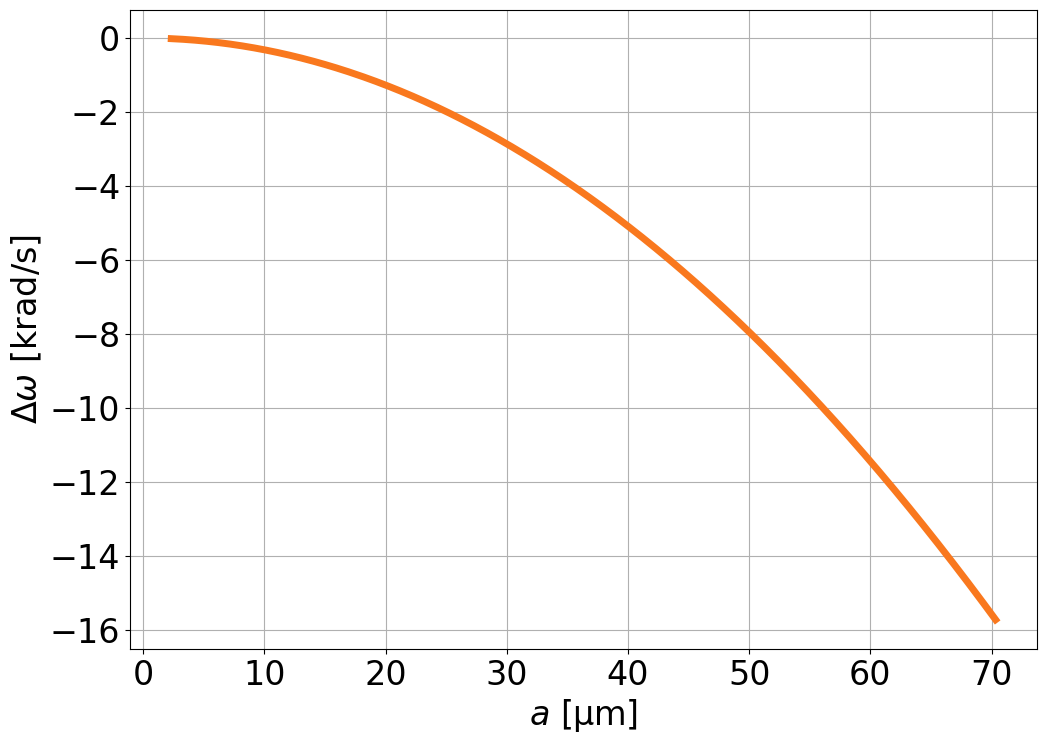

In [479]:
my_ls = ['-','--',':']

figname = 'deltaomega0_vs_a'
fig, ax = plt.subplots(1,num=figname,clear=True,sharex=True)

ax.plot(np.abs( p_roots[2] )*1e6,delta_omega[2]*1e-3/2,
    ls='-',lw=5,
    color=cm(0.76), # royal blue
    marker='')

# ax.plot(np.abs( p_roots[0] )*1e6,delta_omega[0]*1e-3,
#     ls='--',lw=3,
#     color=cm(0.1), # royal blue
#     marker='',
#     label=f'{detuning/Gamma_SP}')

# ax.plot(np.abs( p_roots[1] )*1e6,delta_omega[1]*1e-3,
#     ls=':',lw=3,
#     color=cm(0.45), # royal blue
#     marker='')

ax.grid()

ax.set_xlabel('$a$ [µm]')
ax.set_ylabel('$\Delta \omega$ [krad/s]')

# plt.savefig(figname+'.png',dpi=300)

delta_omega_2 = delta_omega[2]
print(delta_omega_2)
index = int( len(delta_omega_2)*50/70 )
print(index)
print(np.abs(p_roots[2])[index+183])
print(delta_omega_2[index+183])

[-3.82351955e-16 -3.82659016e-16 -3.82966448e-16 ... -3.50715084e-13
 -3.50855021e-13 -3.50994959e-13]
3572
50.01803453050609
-1.775047932899493e-07


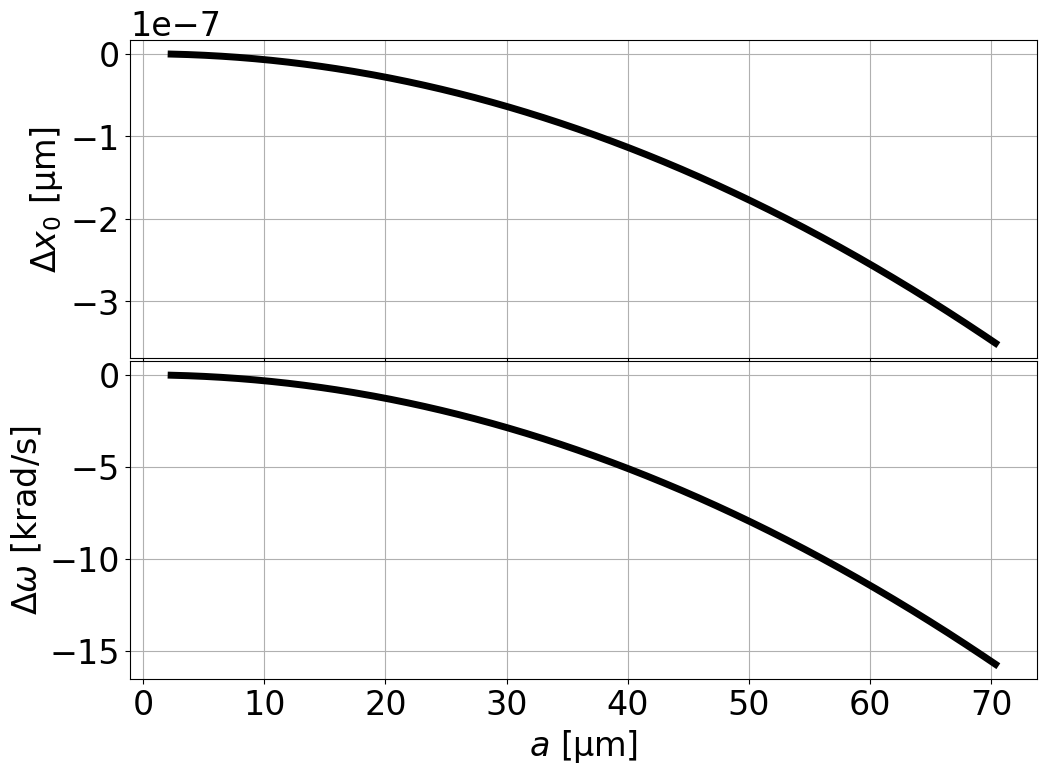

In [485]:
my_ls = ['-','--',':']

figname = 'deltax0_deltaomega_vs_a'
fig, ax = plt.subplots(2,num=figname,
                        clear=True,sharex=True)

ax[0].plot(np.abs(p_roots[2])*1e6,delta_x0[2]*1e6,
    ls='-',lw=5,
    color='k', # royal blue
    marker='')

ax[1].plot(np.abs( p_roots[2] )*1e6,delta_omega[2]*1e-3/2,
    ls='-',lw=5,
    color='k', # royal blue
    marker='')

# ax.plot(np.abs(p_roots[0])*1e6,delta_x0[0]*1e6,
#     ls='--',lw=3,
#     color=cm(0.1), # royal blue
#     marker='',
#     label=f'{detuning/Gamma_SP}')

# ax.plot(np.abs(p_roots[1])*1e6,delta_x0[1]*1e6,
#     ls=':',lw=3,
#     color=cm(0.45), # royal blue
#     marker='')

# ax.plot(p_roots[3]*1e6,delta_x0[2]*1e6,
#     ls='-',lw=2,
#     color=cm(0.76), # royal blue
#     marker='')

# ax.plot(p_roots[5]*1e6,delta_x0[0]*1e6,
#     ls='--',lw=2,
#     color=cm(0.1), # royal blue
#     marker='',
#     label=f'{detuning/Gamma_SP}')

# ax.plot(p_roots[4]*1e6,delta_x0[1]*1e6,
#     ls=':',lw=3,
#     color=cm(0.45), # royal blue
#     marker='')


ax[0].grid()
ax[1].grid()

# ax[0].set_xlabel('$a$ [µm]')
ax[0].set_ylabel('$\Delta x_0$ [µm]')

ax[1].set_xlabel('$a$ [µm]')
ax[1].set_ylabel('$\Delta \omega$ [krad/s]')

plt.subplots_adjust(hspace=0.01)

plt.savefig(figname+'.png',dpi=300)


delta_x0_2 = delta_x0[2]
print(delta_x0_2)
index = int( len(delta_x0_2)*50/70 )
print(index)
print(np.abs(p_roots[2])[index+183]*1e6)
print(delta_x0_2[index+183]*1e6)